In [1]:
#!/usr/bin/env python3
import sys
import smach
import rospy
import cv2 as cv
import numpy as np
from std_srvs.srv import Empty
import moveit_commander
import moveit_msgs.msg
from geometry_msgs.msg import PoseStamped
import tf2_ros as tf2
from tf2_sensor_msgs.tf2_sensor_msgs import do_transform_cloud
from utils_takeshi import *
from grasp_utils import *

In [2]:
global head, wb, arm, tf_man, gaze, robot, scene #wbw, wbl
global rgbd, hand_cam, wrist, gripper, grasp_base, clear_octo_client, service_client, AR_starter, AR_stopper

moveit_commander.roscpp_initialize(sys.argv)
rospy.init_node('pruebas_de_graspeo')

# head = moveit_commander.MoveGroupCommander('head')
# wb = moveit_commander.MoveGroupCommander('whole_body')
# arm =  moveit_commander.MoveGroupCommander('arm')
# wbl = moveit_commander.MoveGroupCommander('whole_body_light')
#wbw.set_workspace([-6.0, -6.0, 6.0, 6.0]) 
#wbl.set_workspace([-6.0, -6.0, 6.0, 6.0])  
# wb.set_workspace([-6.0, -6.0, 6.0, 6.0])  
    
# robot = moveit_commander.RobotCommander()
# scene = moveit_commander.PlanningSceneInterface()

tf_man = TF_MANAGER()
rgbd = RGBD()
hand_cam = HAND_RGB()
wrist = WRIST_SENSOR()
gripper = GRIPPER()
grasp_base = OMNIBASE()
gaze = GAZE()

clear_octo_client = rospy.ServiceProxy('/clear_octomap', Empty)
# AR_starter = rospy.ServiceProxy('/marker/start_recognition',Empty)
# AR_stopper = rospy.ServiceProxy('/marker/stop_recognition',Empty)
  
# head.set_planning_time(0.3)
# head.set_num_planning_attempts(1)
# wb.set_num_planning_attempts(10)

[ WARN] [1676403800.423771104, 2389.338000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2389.380000 according to authority /pose_integrator
[ WARN] [1676403800.426851894, 2389.338000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2389.380000 according to authority /pose_integrator


In [3]:
        #State initial
        gripper.open()
        arm.clear_pose_targets()
        wb.clear_pose_targets()
        try:
            clear_octo_client()
            AR_stopper.call()
        except:
            rospy.loginfo('Cant clear octomap')
        #Takeshi neutral
        arm.set_named_target('go')
        arm.go()
        gripper.steady()
        head.set_named_target('neutral')
        succ = head.go()
        if succ:
            return 'succ'
        else:
            return 'failed'

[INFO] [1668619572.528322]: Cant clear octomap


SyntaxError: 'return' outside function (1740054036.py, line 17)

In [9]:
        # State Find AR marker
        try:
            AR_starter.call()
            clear_octo_client()
        except:
            rospy.loginfo('Cant clear octomap')
        rospy.sleep(0.2)
        arm.set_named_target('go')
        arm.go()
        hcp = gaze.relative(1,0,0.7)
        head.set_joint_value_target(hcp)
        head.go()
        succ = False
        flag = 1
        while not succ:
            trans,rot = tf_man.getTF(target_frame='ar_marker/201', ref_frame='base_link')
            print(trans)
            if type(trans) is not bool:
                tf_man.pub_static_tf(pos=trans, rot=rot, point_name='cassette', ref='base_link')
                rospy.sleep(0.8)
                while not tf_man.change_ref_frame_tf(point_name='cassette', new_frame='map'):
                    rospy.sleep(0.8)
                    rospy.loginfo('Change reference frame is not done yet')
#                 return 'succ'
            else:
                gazeY = 0.5 
                if flag == 1:
                    flag += 1
                elif flag == 2:
                    gazeY = -0.5
                    flag += 1
                else:
                    head.set_named_target('neutral')
                    head.go() 
#                     return 'tries'
                hcp = gaze.relative(0.7,gazeY,0.7)
                head.set_joint_value_target(hcp)
                head.go()
                rospy.sleep(0.3)

[0.5242074844782553, 0.022178741870319017, 0.7754205204591732]
[0.524016966850046, 0.022097696971943158, 0.7754442248469827]
[0.5240937346205395, 0.022088705408340747, 0.7754546992819386]
[0.5240287934481772, 0.022080268509891723, 0.775428517581984]
[0.5240128313841298, 0.022090553187636315, 0.7754287875530522]
[0.5240389837540439, 0.022117928805671414, 0.7754650781357325]
[0.5239528005625766, 0.02209919225298265, 0.7754658283520219]
[0.524063245722513, 0.022094982339602595, 0.7754420018863118]
[0.5239177516341074, 0.022078393405801006, 0.7754482181269222]
[0.5239993184752556, 0.022090116962594605, 0.7754333267425403]
[0.5240754089611993, 0.02212463655782381, 0.775490449459315]
[0.5240214301163418, 0.022113758738646763, 0.7754672916365074]
[0.5240304250792152, 0.02210820389121752, 0.7754477493901414]
[0.5241316363600212, 0.0221100880008964, 0.7754534933700624]
[0.5240922632873372, 0.022113205297784412, 0.7754671430509497]
[0.5241470513462354, 0.02212085138097002, 0.775451841152101]
[0.

KeyboardInterrupt: 

In [10]:
        #AR alignment
        AR_stopper.call()
        head.set_named_target('neutral')
        head.go()
        arm.set_named_target('go')
        arm.go()
        succ = False
        THRESHOLD = 0.08
        while not succ:
            try:
                trans, rot = tf_man.getTF(target_frame='cassette', ref_frame='base_link')
                euler = tf.transformations.euler_from_quaternion(rot)
                theta = euler[2]
                e = theta + 1.57
                rospy.loginfo("Its missing to turn {:.2f} radians".format(e))
                if abs(e) < THRESHOLD:
                    talk("I am aligned")
#                     return 'succ'
                else:
                    rospy.sleep(0.1)
                    grasp_base.tiny_move(velT = 0.4*e, std_time=0.1)
            except:
                print('hola')
#                 return 'tries'

SyntaxError: unexpected EOF while parsing (2898252367.py, line 23)

In [7]:
        # State Pre grasp pose
        gripper.open()
        arm.set_named_target('neutral')
        arm.go()
        #Set pose
        trans = False
        pos = False
        while (type(trans) is bool) and (type(pos) is bool) :
            trans,_ = tf_man.getTF(target_frame='cassette', ref_frame='hand_palm_link')
            pos,_ = tf_man.getTF(target_frame='hand_palm_link', ref_frame='odom')
        tf_man.pub_tf(point_name='goal_pose', pos=[trans[2]+0.1, 0.0, 0.11], ref='hand_palm_link')
        rospy.sleep(0.5)
        pos, rot = tf_man.getTF(target_frame='goal_pose', ref_frame='odom')

        # while type(pos) is bool:
            # print('stucked')
            # pos, rot = tf_man.getTF(target_frame='goal_pose', ref_frame='odom')
        if type(pos) is not bool:
            pose_goal = set_pose_goal(pos=pos, rot=rot)
            arm.set_start_state_to_current_state() 
            arm.set_pose_target(pose_goal)
            succ, plan, _, _ = arm.plan()
            if succ:
                arm.execute(plan)
            else:
                rospy.loginfo('I could not plan to goal pose')
                return 'tries'
        else:
            return 'tries'
        #Align along X and Y axis
        succ = False
        THRESHOLD = 0.01
        while not succ:
            trans,_ = tf_man.getTF(target_frame='cassette', ref_frame='hand_palm_link')
            if type(trans) is not bool:
                _, eY, eX = trans
                rospy.loginfo("Distance to goal: {:.2f}, {:.2f}".format(eX, eY))
                if abs(eY) < THRESHOLD:
                    eY = 0
                if abs(eX) < THRESHOLD:
                    eX = 0
                succ =  eX == 0 and eY == 0
                    # grasp_base.tiny_move(velY=-0.4*trans[1], std_time=0.2, MAX_VEL=0.3)
                grasp_base.tiny_move(velX=0.3*eX, velY=-0.4*eY, std_time=0.2, MAX_VEL=0.3) #Pending test
        return 'succ'

NameError: name 'gripper' is not defined

In [4]:
# FIND AR MARKER
hcp = head.get_current_joint_values()
# print(hcp)
hcp[0]=0.4
hcp[1]= -0.2
head.set_joint_value_target(hcp)
head.go()
succ = False
last = 0
while not succ:
    try:
        t = tfbuff.lookup_transform('base_link', 'ar_marker/201', rospy.Time(0) )
        rospy.sleep(0.3)
        trans, _ = tf2_obj_2_arr(t)
        distanceX = trans[0]
        print(distanceX)
        if distanceX < 0.60 and distanceX > 0.55:
            hcp = head.get_current_joint_values()
            hcp[0] += 0.3
            hcp[1] = -0.2
            head.set_joint_value_target(hcp)
            head.go()
        if distanceX < 0.45:
            succ = True
        else:
            tiny_move_base(x=0.5,std_time=0.1)
    except:
        tiny_move_base(x=0.5,std_time=0.1)

KeyboardInterrupt: 

In [5]:
tiny_move_base(theta=1.5707,std_time=2)

In [5]:
# arm.set_named_target('neutral')

# arm.go()
hcp = head.get_current_joint_values()
hcp[0] = -0.1
hcp[1] = -0.5
head.set_joint_value_target(hcp)
head.go()
# start_AR_recognition()
# starter = rospy.ServiceProxy('/marker/start_recognition',Empty)
# stopper = rospy.ServiceProxy('/marker/stop_recognition', Empty)

True

In [4]:
starter.call()
# static_publish_ARmarker()

[[-0.12267153  0.413494    1.1211635 ]
 [-0.10409301  0.31896338  1.2245353 ]
 [-0.575319    0.33617282  1.1287789 ]
 [-1.0722715  -0.97066474  3.063259  ]]


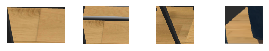

[ WARN] [1661539857.577818147, 230.766000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 230.784000 according to authority /pose_integrator
[ WARN] [1661539857.578063668, 230.766000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 230.784000 according to authority unknown_publisher
[ WARN] [1661539864.196925861, 232.002000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 232.026000 according to authority /pose_integrator
[ WARN] [1661539864.200189622, 232.002000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 232.026000 according to authority unknown_publisher
[ WARN] [1661539864.774273744, 232.128000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 232.227000 according to authority unknown_publisher
[ WARN] [1661539864.779747023, 232.128000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame

[ WARN] [1661539980.361936090, 252.246000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 252.288000 according to authority unknown_publisher
[ WARN] [1661539980.363259660, 252.246000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 252.288000 according to authority /pose_integrator
[ WARN] [1661539988.046171832, 253.950000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 253.989000 according to authority /pose_integrator
[ WARN] [1661539988.047416990, 253.950000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 253.989000 according to authority unknown_publisher
[ WARN] [1661539988.656922233, 254.046000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 254.112000 according to authority unknown_publisher
[ WARN] [1661539988.657654747, 254.046000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame

[ WARN] [1661540106.356728982, 274.746000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 274.785000 according to authority unknown_publisher
[ WARN] [1661540106.358084764, 274.746000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 274.785000 according to authority /pose_integrator
[ WARN] [1661540111.359904547, 275.589000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 275.616000 according to authority /pose_integrator
[ WARN] [1661540111.361483919, 275.589000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 275.616000 according to authority unknown_publisher
[ WARN] [1661540130.327886225, 278.850000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 278.850000 according to authority /pose_integrator
[ WARN] [1661540130.347794117, 278.850000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame 

[ WARN] [1661540282.757965271, 305.754000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 305.754000 according to authority /pose_integrator
[ WARN] [1661540282.759377055, 305.754000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 305.754000 according to authority unknown_publisher
[ WARN] [1661540288.678249746, 306.810000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 306.846000 according to authority /pose_integrator
[ WARN] [1661540288.682255046, 306.810000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 306.846000 according to authority unknown_publisher
[ WARN] [1661540312.141483067, 310.707000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 310.731000 according to authority /pose_integrator
[ WARN] [1661540312.143230207, 310.707000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame 

[ WARN] [1661540408.950075100, 326.766000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 326.808000 according to authority unknown_publisher
[ WARN] [1661540408.950204971, 326.766000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 326.808000 according to authority /pose_integrator
[ WARN] [1661540414.070570810, 327.726000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 327.780000 according to authority /pose_integrator
[ WARN] [1661540414.070811246, 327.726000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 327.780000 according to authority unknown_publisher
[ WARN] [1661540415.718333390, 328.020000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 328.113000 according to authority unknown_publisher
[ WARN] [1661540415.718750410, 328.020000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame

[ WARN] [1661540431.099456094, 330.777000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 330.768000 according to authority unknown_publisher
[ WARN] [1661540431.100651275, 330.777000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 330.768000 according to authority /pose_integrator
[ WARN] [1661540433.376458974, 331.095000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 331.209000 according to authority /pose_integrator
[ WARN] [1661540433.380301240, 331.095000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 331.209000 according to authority unknown_publisher
[ WARN] [1661540436.496090448, 331.662000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 331.683000 according to authority unknown_publisher
[ WARN] [1661540436.497282254, 331.662000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame

[ WARN] [1661540446.377084040, 333.465000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 333.495000 according to authority unknown_publisher
[ WARN] [1661540446.391830640, 333.465000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 333.495000 according to authority /pose_integrator
[ WARN] [1661540447.329434369, 333.648000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 333.705000 according to authority /pose_integrator
[ WARN] [1661540447.329658673, 333.648000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 333.705000 according to authority unknown_publisher
[ WARN] [1661540450.484127727, 334.101000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 334.149000 according to authority /pose_integrator
[ WARN] [1661540450.490304526, 334.101000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame 

In [10]:
# arm.get_current_joint_values()
# close_gripper(1)
# open_gripper(0.5)
cents, xyz, images = plane_seg_square_imgs(lower=500, higher= 9000,low_plane=0.0,high_plane=0.7)
print(cents)

In [8]:
tfbuff.lookup_transform('base_link','ar_marker/201',rospy.Time(0))

header: 
  seq: 0
  stamp: 
    secs: 1663181324
    nsecs: 633357286
  frame_id: "base_link"
child_frame_id: "ar_marker/201"
transform: 
  translation: 
    x: 0.5901338296430858
    y: 0.5444007193021916
    z: 0.6943078975420713
  rotation: 
    x: -0.9921537780872313
    y: -0.048471471905746466
    z: 0.011546236702967599
    w: 0.11466508385957298

In [7]:
t = tfbuff.lookup_transform('base_link','ar_marker/201',rospy.Time(0))
trans,rot = tf2_obj_2_arr(t)
print(rot)
tf.transformations.euler_from_quaternion(rot)

[-0.9907683411141247, -0.07520694940789449, 0.0229383361916285, 0.11043478500673563]


(-2.917344570848489, 0.02884622836342712, 0.15477302553663333)

In [9]:
t = tfbuff.lookup_transform('base_link','ar_marker/201',rospy.Time(0))
trans,rot = tf2_obj_2_arr(t)
print(rot)
tf.transformations.euler_from_quaternion(rot)

[-0.7059708202192447, 0.6953403211755309, -0.09173526642618814, 0.09844632872886791]


(-2.8717475022302272, 0.007382628172537523, -1.554622223577454)

In [23]:
# intento de vuelta
succ = False
THRESHOLD = 0.1
hcp = [0.6,-0.1]
flag = True
while not succ:
    try:
        t = tfbuff.lookup_transform('base_link','ar_marker/201',rospy.Time(0))
        _, rot = tf2_obj_2_arr(t)
#     print(rot)
        euler = tf.transformations.euler_from_quaternion(rot)
        theta = euler[2]
        e = theta + 1.57
        print(e)
        if abs(e) < THRESHOLD:
            print('estoy alineado krnal')
            succ = True
            hcp[0] = 0.0
            head.set_joint_value_target(hcp)
            head.go()
        else:
            rospy.sleep(0.55)
            tiny_move_base(theta = 0.02*e, std_time=0.2)
    except:
        hcp[0] -= 0.2
        head.set_joint_value_target(hcp)
        head.go()
        

1.528891340943456
1.5234766078038895
1.5226312936974002
1.3789880517267126
1.2645262403092452
1.1875323262261157
1.0857421655506934
1.0333927611450127
0.8905882694630014
0.9172924317788429
0.9172924317788429
0.9172924317788429
0.9172924317788429
0.9172924317788429
0.9172924317788429
0.9172924317788429
0.9172924317788429
0.9172924317788429
0.9172924317788429
0.9172924317788429
0.9172924317788429
-0.018372864206141815
estoy alineado krnal
shutdown request: new node registered with same name


In [7]:
hcp=[0,0]
hcp[0]= 0.6
hcp[1]= -0.1
head.set_joint_value_target(hcp)
head.go()
        

False

In [31]:
acp = arm.get_current_joint_values()
acp[0] = 0.69
arm.set_joint_value_target(acp)
arm.go()

True

In [32]:
acp = arm.get_current_joint_values()
acp[0] = 0.69
arm.set_joint_value_target(acp)
arm.go()
rospy.sleep(0.3)
tiny_move_base(x=-0.2)
arm.set_named_target('go')
arm.go()

True

In [29]:
arm.set_named_target('neutral')
arm.go()

False

In [39]:
tiny_move_base(y = 0.1,std_time=0.1)

In [13]:
X_OFFSET = 0.0
Y_OFFSET = 0.19
Z_OFFSET = 0.135

# X_OFFSET = 0.0
# Y_OFFSET = 0.0
# Z_OFFSET = 0.135
THRESHOLD = 0.025
# THRESHOLD_y = 0.015
hcp = head.get_current_joint_values()
hcp[0] = -0.1
hcp[1] = -0.5
head.set_joint_value_target(hcp)
head.go()
while(True):
    try:
        t = tfbuff.lookup_transform('hand_palm_link', 'ar_marker/201', rospy.Time(0) )
#         t = tfbuff.lookup_transform('hand_palm_link', 'ar_marker/4000', rospy.Time(0) )
        traf = t.transform.translation
        rospy.sleep(.6)
        # tiny_move_base(y = 0.163)
        ex = x = traf.x + X_OFFSET
        ey = -traf.y + Y_OFFSET
        print(ex, ey)
        if abs(ex) > THRESHOLD:
            tiny_move_base(x = ex)#, y = -traf.y + Y_OFFSET)
        if abs(ey) > THRESHOLD:
            tiny_move_base(y = ey)
        if (abs(ex) <= THRESHOLD and abs(ey) <= THRESHOLD):
            hcp[0] = 0
            head.set_joint_value_target(hcp)
            head.go()
            break
    except:
        hcp = head.get_current_joint_values()
        hcp[0] -= 0.1   
        print(hcp[0])
        head.set_joint_value_target(hcp)
        head.go()
        if hcp[0] < -1:
            hcp[0] = 0.1
            head.set_joint_value_target(hcp)
            head.go()
            print('Ive lost the reference')
            break

0.18206044985683112 -0.07963676197958103
0.18077576898262848 -0.08204285837805414
0.16376267821065316 -0.05799227993958983
0.14912171320579481 -0.029690443332722694
0.1297656616285232 -0.006464209257546261
0.11706898613260186 0.011072387461636468
0.09961603066927394 0.025464086583341705
0.06165537424209311 0.03123962812630171
0.042112388788395294 0.004777305724930236
0.029347725306565264 -0.009126465317773003
0.019078794314005942 -0.02641238450546396
-0.01923277895010389 -0.02557613299206324
-0.035685880512142276 -0.026318878588169448
-0.035685880512142276 -0.026318878588169448
-0.032739539748185775 0.02910410571583938
-0.01566133829922778 0.03699763488155755
-0.01566133829922778 0.03699763488155755
0.0012475152873097084 0.017285147550490765


In [16]:
hand_cam.get_image()

array([[[16, 16, 16],
        [16, 16, 16],
        [11, 18, 14],
        ...,
        [20, 15, 18],
        [16, 15, 18],
        [16, 15, 18]],

       [[18, 16, 16],
        [18, 16, 16],
        [16, 16, 16],
        ...,
        [20, 15, 18],
        [13, 16, 18],
        [13, 16, 18]],

       [[16, 16, 16],
        [16, 16, 16],
        [13, 17, 16],
        ...,
        [20, 15, 18],
        [16, 15, 18],
        [16, 15, 18]],

       ...,

       [[16, 16, 16],
        [16, 16, 16],
        [16, 16, 16],
        ...,
        [20, 17, 13],
        [20, 16, 16],
        [20, 16, 16]],

       [[16, 16, 16],
        [16, 16, 16],
        [16, 16, 16],
        ...,
        [20, 16, 16],
        [16, 16, 16],
        [16, 16, 16]],

       [[16, 16, 16],
        [16, 16, 16],
        [16, 16, 16],
        ...,
        [20, 17, 13],
        [16, 16, 16],
        [16, 16, 16]]], dtype=uint8)

In [117]:
tr = tfbuff.lookup_transform('head_l_stereo_camera_frame', 'ar_marker/201', rospy.Time(0))
print(tr)

header: 
  seq: 0
  stamp: 
    secs: 1662408747
    nsecs: 123095036
  frame_id: "head_l_stereo_camera_frame"
child_frame_id: "ar_marker/201"
transform: 
  translation: 
    x: -0.14347501605042673
    y: 0.15732225270132918
    z: 0.5154270624021277
  rotation: 
    x: -0.3222956746461686
    y: -0.1456418210249864
    z: -0.2527666914397325
    w: 0.9005681305551001


In [95]:
tiny_move_base(x=-ex)
# tiny_move_base(y = -ey)
print(ex,ey)

-0.18241688078796336 -0.03828563605475077


[WARN] [1661454076.973070]: Inbound TCP/IP connection failed: connection from sender terminated before handshake header received. 0 bytes were received. Please check sender for additional details.


In [45]:
acp = arm.get_current_joint_values()
acp[0]-= 0.01
arm.set_pose_target(acp)
arm.go()

False

In [24]:
transf = tfbuff.lookup_transform('map', 'cassette', rospy.Time(0))
trans,_= tf2_obj_2_arr(transf)

transf2 = tfbuff.lookup_transform('map', 'hand_palm_link', rospy.Time(0))
trans2,_ = tf2_obj_2_arr(transf2)

e = trans2[1]-trans[1]
wb_cp = whole_body.get_current_pose()
wb_cp.pose.position.y += e
whole_body.set_pose_target(wb_cp)
whole_body.go()

print(e)

0.008520200142226764


In [13]:
arm.set_named_target('neutral')
arm.go()

True

In [19]:
armCV=arm.get_current_joint_values()
armCV[4]=0
arm.set_joint_value_target(armCV)
arm.go()

True

In [9]:
        grasp_from_above_joints=[0.59,-1.3376,0,-1.8275,0.0,0.0]
        arm.set_joint_value_target(grasp_from_above_joints)
        succ = arm.go()

[ WARN] [1663893119.067582684, 58.809000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 58.878000 according to authority unknown_publisher
[ WARN] [1663893119.068682608, 58.809000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 58.878000 according to authority /pose_integrator
[ WARN] [1663893119.904871982, 58.995000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 59.019000 according to authority unknown_publisher
[ WARN] [1663893119.905679698, 58.995000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 59.019000 according to authority /pose_integrator
[ WARN] [1663893124.766849215, 59.454000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 59.502000 according to authority /pose_integrator
[ WARN] [1663893124.769590969, 59.454000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at tim

In [13]:
import sys
import copy
import rospy
import moveit_commander
import moveit_msgs.msg
import geometry_msgs.msg
display_trajectory_publisher = rospy.Publisher(
            "/move_group/display_planned_path",
            moveit_msgs.msg.DisplayTrajectory,
            queue_size=20,
        )
waypoints = []
scale = 1
wpose = whole_body.get_current_pose().pose
wpose.position.z += scale * 0.1  # First move up (z)
waypoints.append(copy.deepcopy(wpose))

wpose.position.x += scale * 0.1  # Second move forward/backwards in (x)
wpose.position.y += scale * 0.1
waypoints.append(copy.deepcopy(wpose))

(plan, fraction) = arm.compute_cartesian_path(
    waypoints, 0.01, 0.0  # waypoints to follow  # eef_step
)  # jump_threshold
display_trajectory = moveit_msgs.msg.DisplayTrajectory()
display_trajectory.trajectory_start = robot.get_current_state()
display_trajectory.trajectory.append(plan)
# Publish
display_trajectory_publisher.publish(display_trajectory)
print(fraction)

0.0


[ WARN] [1663893236.010020806, 71.559000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 71.589000 according to authority unknown_publisher
[ WARN] [1663893236.011090905, 71.559000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 71.589000 according to authority /pose_integrator
[ WARN] [1663893242.093210993, 72.153000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 72.201000 according to authority unknown_publisher
[ WARN] [1663893242.098812416, 72.153000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 72.201000 according to authority /pose_integrator
[ WARN] [1663893254.910834482, 73.461000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 73.509000 according to authority /pose_integrator
[ WARN] [1663893254.911142835, 73.461000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at tim

[ WARN] [1663893403.663462274, 89.466000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 89.502000 according to authority /pose_integrator
[ WARN] [1663893403.664179987, 89.466000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 89.502000 according to authority unknown_publisher
[ WARN] [1663893409.734886901, 90.111000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 90.138000 according to authority unknown_publisher
[ WARN] [1663893409.736443690, 90.111000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 90.138000 according to authority /pose_integrator
[ WARN] [1663893411.611596228, 90.303000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 90.327000 according to authority /pose_integrator
[ WARN] [1663893411.612508082, 90.303000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at tim

[ WARN] [1663893575.486823795, 108.705000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 108.813000 according to authority /pose_integrator
[ WARN] [1663893575.492731570, 108.705000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 108.813000 according to authority unknown_publisher
[ WARN] [1663893583.755039970, 109.602000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 109.635000 according to authority unknown_publisher
[ WARN] [1663893583.755099672, 109.602000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 109.635000 according to authority /pose_integrator
[ WARN] [1663893584.360921202, 109.683000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 109.710000 according to authority /pose_integrator
[ WARN] [1663893584.364897425, 109.683000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame 

[ WARN] [1663893797.440355868, 131.250000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 131.298000 according to authority unknown_publisher
[ WARN] [1663893797.441406669, 131.250000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 131.298000 according to authority /pose_integrator
[ WARN] [1663893817.982343735, 133.131000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 133.173000 according to authority unknown_publisher
[ WARN] [1663893817.982444636, 133.131000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 133.173000 according to authority /pose_integrator
[ WARN] [1663893821.753327433, 133.575000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 133.638000 according to authority unknown_publisher
[ WARN] [1663893821.753818721, 133.575000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame

[ WARN] [1663894027.259440768, 151.335000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 151.377000 according to authority /pose_integrator
[ WARN] [1663894027.263878592, 151.335000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 151.377000 according to authority unknown_publisher
[ WARN] [1663894032.221163062, 151.746000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 151.827000 according to authority unknown_publisher
[ WARN] [1663894032.221813247, 151.746000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 151.827000 according to authority /pose_integrator
[ WARN] [1663894036.638149136, 152.100000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 152.199000 according to authority unknown_publisher
[ WARN] [1663894036.638651268, 152.100000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame

[ WARN] [1663894188.363683996, 165.498000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 165.555000 according to authority /pose_integrator
[ WARN] [1663894188.364976351, 165.498000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 165.555000 according to authority unknown_publisher
[ WARN] [1663894190.604333493, 165.819000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 165.861000 according to authority unknown_publisher
[ WARN] [1663894190.605220767, 165.819000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 165.861000 according to authority /pose_integrator
[ WARN] [1663894193.566340997, 165.984000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 166.047000 according to authority /pose_integrator
[ WARN] [1663894193.567132978, 165.984000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame 

[ WARN] [1663894347.370455642, 182.919000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 182.985000 according to authority /pose_integrator
[ WARN] [1663894347.370914372, 182.919000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 182.985000 according to authority unknown_publisher


In [24]:
        open_gripper()
        rospy.sleep(0.3)
        acp = [0.56,-1.3376,0,-1.8275,0.0,0.0]
        arm.set_joint_value_target(acp)
        arm.go()
        close_gripper()
        rospy.sleep(0.3)
#         gripper.command(0.0) #close
        
        check_grasp_joints=[0.69,-1.3376,0,-1.8275,0.0,0.0]
        arm.set_joint_value_target(check_grasp_joints)
        arm.go()
        
        check_grasp_joints=[0.69,-1.3376,-0.8,-1.8275,0.0,0.0]
        arm.set_joint_value_target(check_grasp_joints)
        arm.go()

[ WARN] [1663897315.859170131, 504.933000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 504.996000 according to authority /pose_integrator
[ WARN] [1663897315.871492443, 504.933000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 504.996000 according to authority unknown_publisher
[ WARN] [1663897322.743384420, 505.869000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 505.902000 according to authority /pose_integrator
[ WARN] [1663897322.749883126, 505.869000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 505.902000 according to authority unknown_publisher
[ WARN] [1663897327.153289555, 506.397000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 506.523000 according to authority /pose_integrator
[ WARN] [1663897327.154054708, 506.397000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame 

True

[ WARN] [1663897405.817101651, 515.097000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame arm_flex_link at time 515.316000 according to authority /robot_state_publisher
[ WARN] [1663897405.817379729, 515.097000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame arm_lift_link at time 515.316000 according to authority /robot_state_publisher
[ WARN] [1663897405.817503343, 515.097000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame arm_roll_link at time 515.316000 according to authority /robot_state_publisher
[ WARN] [1663897405.817627162, 515.097000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame base_b_bumper_link at time 515.316000 according to authority /robot_state_publisher
[ WARN] [1663897405.817742345, 515.097000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame base_f_bumper_link at time 515.316000 according to authority /robot_state_publisher
[ WARN] [1663897405.817876115,

[ WARN] [1663897411.491589583, 515.697000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 515.727000 according to authority unknown_publisher
[ WARN] [1663897411.491666816, 515.697000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 515.727000 according to authority /pose_integrator


In [11]:
whole_body.execute(plan)

False

[ WARN] [1663893192.794081619, 67.158000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 67.209000 according to authority unknown_publisher
[ WARN] [1663893192.795523278, 67.158000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 67.209000 according to authority /pose_integrator
[ WARN] [1663893200.189194602, 68.010000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 68.040000 according to authority /pose_integrator
[ WARN] [1663893200.191104056, 68.010000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 68.040000 according to authority unknown_publisher
[ WARN] [1663893200.692492538, 68.076000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 68.112000 according to authority unknown_publisher
[ WARN] [1663893200.692822747, 68.076000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at ti

In [22]:
open_gripper()

In [6]:
        gripper.open()
#         arm.set_named_target('neutral')
#         arm.go()
        #Set pose
        trans = False
        pos = False
#         i=1
        while (type(trans) is bool) and (type(pos) is bool) :
#             print(i)
#             i =+1
            trans,_ = tf_man.getTF(target_frame='cassette', ref_frame='hand_palm_link')
            pos,_ = tf_man.getTF(target_frame='hand_palm_link', ref_frame='odom')
        tf_man.pub_tf(point_name='goal_pose', pos=[trans[2]+0.1, 0.0, 0.11], ref='hand_palm_link')
        rospy.sleep(0.5)
        pos, rot = tf_man.getTF(target_frame='goal_pose', ref_frame='odom')

        if type(pos) is not bool:
            pose_goal = set_pose_goal(pos=pos, rot=rot)
#             arm.set_start_state_to_current_state() 
#             arm.set_pose_target(pose_goal)
            succ, plan, _, _ = arm.plan()
            if succ:
#                 print(plan)
                arm.execute(plan)
            else:
                rospy.loginfo('I could not plan to goal pose')
                return 'tries'
        else:
            return 'tries'

1


TypeError: 'bool' object is not subscriptable

In [8]:
from grasp_utils import *
grip = GRIPPER()

In [13]:
grip.close()

In [16]:
grip.open()

In [17]:
grip.steady()

In [3]:
rospy.init_node('tfs')
tf_man = TF_MANAGER()

In [4]:
pos, rot = tf_man.getTF(target_frame='ar_marker/7', ref_frame='base_link')

In [5]:
tf.transformations.euler_from_quaternion(rot)

TypeError: 'bool' object is not subscriptable

In [36]:

trans,rot = tf_man.getTF(target_frame='ar_marker/7', ref_frame='base_link')
euler = tf.transformations.euler_from_quaternion(rot)
theta = euler[2] 
if type(trans) is not bool:
    eX, eY, _ = trans
    eY = eY 
    eX -= 0.40
    eT = theta + 1.57
    print(eX,eY, eT)
    grasp_base.tiny_move(velX=0.1*eX, velY=0.1*eY, velT= 0.1*eT, std_time=0.2)

0.10773587915765426 0.029705648429379564 0.023337468704812014


In [3]:
import moveit_commander
import moveit_msgs
import geometry_msgs
import numpy as np

In [9]:
# import moveit_commander
# import moveit_msgs
# import geometry_msgs
# import numpy as np
# import tf

# Create a move group for the manipulator
# move_group = moveit_commander.MoveGroupCommander("manipulator")

# Set the planner to use
# move_group.set_planner_id("RRTConnectkConfigDefault")

# Set the reference frame for the points
# move_group.set_pose_reference_frame("base_link")

# Set the maximum velocity and acceleration for the group
# move_group.set_max_velocity_scaling_factor(0.5)
# move_group.set_max_acceleration_scaling_factor(0.5)

move_group = arm

# Create an empty trajectory
trajectory = moveit_msgs.msg.RobotTrajectory()
print(trajectory)
arm.set_named_target('neutral')
arm.go()
# Add each target as a waypoint in the trajectory
for theta in range (0, 90):
    # Create a pose for the target
    deg = np.deg2rad(theta)
    
    pose = geometry_msgs.msg.Pose()
    pose.position.x = 0.0
    pose.position.y = np.sin(deg)
    pose.position.z = np.cos(deg)
#     quat = tf.transformations.quaternion_from_euler(target[3], target[4], target[5])
#     pose.orientation.x = quat[0]
#     pose.orientation.y = quat[1]
#     pose.orientation.z = quat[2]
    pose.orientation.w = 1
    
    # Add the target as a waypoint to the trajectory
    trajectory.joint_trajectory.points.append add_point(move_group.get_current_pose().pose, move_group.get_current_velocity(), 0.0, pose, [0.0, 0.0, 0.0], [0.0, 0.0, 0.0])

# Plan the trajectory
plan = move_group.plan(trajectory)

# Execute the plan
move_group.execute(plan)


joint_trajectory: 
  header: 
    seq: 0
    stamp: 
      secs: 0
      nsecs:         0
    frame_id: ''
  joint_names: []
  points: []
multi_dof_joint_trajectory: 
  header: 
    seq: 0
    stamp: 
      secs: 0
      nsecs:         0
    frame_id: ''
  joint_names: []
  points: []


TypeError: unhashable type: 'RobotTrajectory'

[ WARN] [1673311527.040089824, 2520.018000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2520.050000 according to authority /pose_integrator
[ WARN] [1673311527.040173477, 2520.018000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2520.050000 according to authority /pose_integrator
[ WARN] [1673311527.043798834, 2520.018000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2520.050000 according to authority unknown_publisher
[ WARN] [1673311534.060574463, 2521.164000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2521.196000 according to authority /pose_integrator
[ WARN] [1673311534.060653978, 2521.164000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2521.196000 according to authority /pose_integrator
[ WARN] [1673311534.060775056, 2521.164000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1673311761.177326033, 2561.385000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2561.407000 according to authority /pose_integrator
[ WARN] [1673311761.177406534, 2561.385000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2561.407000 according to authority /pose_integrator
[ WARN] [1673311761.177952017, 2561.385000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2561.407000 according to authority unknown_publisher
[ WARN] [1673311767.661363527, 2562.363000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2562.379000 according to authority unknown_publisher
[ WARN] [1673311767.664368670, 2562.363000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2562.379000 according to authority /pose_integrator
[ WARN] [1673311767.664540298, 2562.363000000]: TF_REPEATED_DATA ignoring data with redundant timestamp

In [11]:
move_group = moveit_commander.MoveGroupCommandInterpreter() 

[ WARN] [1673312589.133236230, 2703.711000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2703.751000 according to authority /pose_integrator
[ WARN] [1673312589.133330313, 2703.711000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2703.751000 according to authority /pose_integrator
[ WARN] [1673312589.140468264, 2703.711000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2703.751000 according to authority unknown_publisher
[ WARN] [1673312652.903702835, 2713.257000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2713.307000 according to authority unknown_publisher
[ WARN] [1673312652.905322149, 2713.257000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2713.307000 according to authority /pose_integrator
[ WARN] [1673312652.905481677, 2713.257000000]: TF_REPEATED_DATA ignoring data with redundant timestamp

[ WARN] [1673313197.469442818, 2806.095000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2806.120000 according to authority /pose_integrator
[ WARN] [1673313197.469638890, 2806.095000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2806.120000 according to authority /pose_integrator
[ WARN] [1673313197.470908730, 2806.095000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2806.120000 according to authority unknown_publisher
[ WARN] [1673313230.366060556, 2812.082000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2812.120000 according to authority /pose_integrator
[ WARN] [1673313230.366163828, 2812.082000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2812.120000 according to authority /pose_integrator
[ WARN] [1673313230.368407540, 2812.082000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1673313573.925574658, 2874.242000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2874.283000 according to authority /pose_integrator
[ WARN] [1673313573.925670234, 2874.242000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2874.283000 according to authority /pose_integrator
[ WARN] [1673313573.926436245, 2874.242000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2874.283000 according to authority unknown_publisher
[ WARN] [1673313660.913938691, 2889.287000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2889.328000 according to authority unknown_publisher
[ WARN] [1673313660.914672154, 2889.287000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2889.328000 according to authority /pose_integrator
[ WARN] [1673313660.914732910, 2889.287000000]: TF_REPEATED_DATA ignoring data with redundant timestamp

[ WARN] [1673313899.217870033, 2930.805000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2930.839000 according to authority unknown_publisher
[ WARN] [1673313899.233962653, 2930.805000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2930.839000 according to authority /pose_integrator
[ WARN] [1673313899.234064889, 2930.805000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2930.839000 according to authority /pose_integrator
[ WARN] [1673313915.899682535, 2933.295000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2933.357000 according to authority /pose_integrator
[ WARN] [1673313915.899854078, 2933.295000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2933.357000 according to authority /pose_integrator
[ WARN] [1673313915.905554584, 2933.295000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

In [23]:


wbw = moveit_commander.MoveGroupCommander('whole_body_weighted')

[ WARN] [1673316532.450148778, 3410.584000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3410.635000 according to authority unknown_publisher
[ WARN] [1673316561.557681852, 3417.602000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3410.635000 according to authority /pose_integrator
[ WARN] [1673316561.557828271, 3417.602000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3410.635000 according to authority /pose_integrator
[ WARN] [1673316564.745600967, 3418.389000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3418.445000 according to authority unknown_publisher
[ WARN] [1673316564.746124260, 3418.389000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3418.445000 according to authority /pose_integrator
[ WARN] [1673316564.746183999, 3418.389000000]: TF_REPEATED_DATA ignoring data with redundant timestamp

In [20]:
arm.set_named_target('neutral')
arm.go()
_,rot =tf_man.getTF(target_frame='hand_palm_link', ref_frame='odom')
waypoints = []
Pose.position.x = 0.5
Pose.position.y = 0.5
Pose.position.z = 0.5

Pose.orientation.x = rot[0]
Pose.orientation.y = rot[1]
Pose.orientation.z = rot[2]
Pose.orientation.w = rot[3]

Pose2 = geometry_msgs.msg.Pose()
Pose2.position.x = 0.5
Pose2.position.y = -0.5
Pose2.position.z = 0.5
Pose2.orientation.x = rot[0]
Pose2.orientation.y = rot[1]
Pose2.orientation.z = rot[2]
Pose2.orientation.w = rot[3]
Pose3 = geometry_msgs.msg.Pose()
Pose3.position.x = -0.5
Pose3.position.y = -0.5
Pose3.position.z = 0.5
Pose3.orientation.x = rot[0]
Pose3.orientation.y = rot[1]
Pose3.orientation.z = rot[2]
Pose3.orientation.w = rot[3]

waypoints.append(Pose)
waypoints.append(Pose2)
waypoints.append(Pose3)

# Plan a path for the end effector to follow
(plan, fraction) = wb.compute_cartesian_path(waypoints, 0.01, 0.0)

# Execute the planned path
wb.execute(plan)

[ WARN] [1673315594.426131730, 3211.305000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3211.342000 according to authority /pose_integrator
[ WARN] [1673315594.426205178, 3211.305000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3211.342000 according to authority /pose_integrator
[ WARN] [1673315594.428382081, 3211.305000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3211.342000 according to authority unknown_publisher
[ WARN] [1673315597.006372420, 3211.806000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3211.857000 according to authority /pose_integrator
[ WARN] [1673315597.006446069, 3211.806000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3211.857000 according to authority /pose_integrator
[ WARN] [1673315597.010439847, 3211.806000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

False

[ WARN] [1673315822.891646192, 3258.117000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3258.170000 according to authority /pose_integrator
[ WARN] [1673315822.891767874, 3258.117000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3258.170000 according to authority /pose_integrator
[ WARN] [1673315822.894591361, 3258.117000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3258.170000 according to authority unknown_publisher
[ WARN] [1673315833.667340595, 3260.424000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3260.481000 according to authority /pose_integrator
[ WARN] [1673315833.667436160, 3260.424000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3260.481000 according to authority /pose_integrator
[ WARN] [1673315833.667505545, 3260.424000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

In [15]:
arm.set_named_target('neutral')
arm.go()
pos,rot =tf_man.getTF(target_frame='hand_palm_link', ref_frame='odom')
waypoints = []

for i in range(0,360):
    theta = np.deg2rad(i)
    Pose = geometry_msgs.msg.Pose()
    Pose.position.x = 0.0
    Pose.position.y = 0.2*np.sin(theta) + pos[1]
    Pose.position.z = 0.3*np.cos(theta) + pos[2]

    Pose.orientation.x = rot[0]
    Pose.orientation.y = rot[1]
    Pose.orientation.z = rot[2]
    Pose.orientation.w = rot[3]


    waypoints.append(Pose)


# Plan a path for the end effector to follow
(plan, fraction) = wb.compute_cartesian_path(waypoints, 0.01, 0.0)

print(fraction)

# Execute the planned path
wb.execute(plan)

1.0


False

In [11]:
display_trajectory_publisher = rospy.Publisher(
    "/move_group/display_planned_path",
    moveit_msgs.msg.DisplayTrajectory,
    queue_size=20,
)

In [12]:
##Display trajectory
robot = moveit_commander.RobotCommander()
display_trajectory = moveit_msgs.msg.DisplayTrajectory()
display_trajectory.trajectory_start = robot.get_current_state()
display_trajectory.trajectory.append(plan)
# Publish
display_trajectory_publisher.publish(display_trajectory)

[ WARN] [1673318253.549586022, 2477.820000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2477.874000 according to authority unknown_publisher
[ WARN] [1673318253.550840123, 2477.820000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2477.874000 according to authority /pose_integrator
[ WARN] [1673318253.552161862, 2477.820000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2477.874000 according to authority /pose_integrator
[ WARN] [1673318272.433832996, 2482.545000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2482.573000 according to authority unknown_publisher
[ WARN] [1673318272.439533358, 2482.573000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2482.573000 according to authority /pose_integrator
[ WARN] [1673318272.439846278, 2482.573000000]: TF_REPEATED_DATA ignoring data with redundant timestamp

In [7]:
tf_man.getTF(target_frame='hand_palm_link', ref_frame='base_link')

[[0.15805690187737723, 0.07799969663624323, 0.8254968539565795],
 [-8.301068150751266e-05,
  -4.332608288021555e-10,
  -0.9999999964748175,
  -1.2632951125992185e-05]]